# Restaurant Revenue Prediction <a id="goback"> </a>

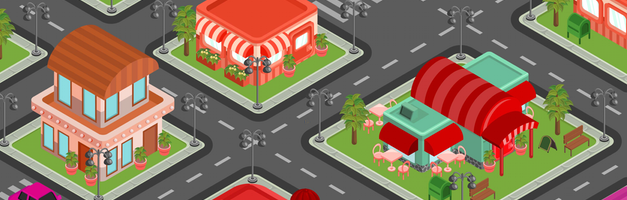

With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred. 

Finding a mathematical model to increase the effectiveness of investments in new restaurant sites would allow TFI to invest more in other important business areas, like sustainability, innovation, and training for new employees. Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

- **Dataset Summary** <br>
    - **Id** : Restaurant id. <br>
    - **Open Date** : opening date for a restaurant <br>
    - **City** : City that the restaurant is in. Note that there are unicode in the names.  <br>
    - **City Group** : Type of the city. Big cities, or Other. <br>
    - **Type**: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile <br>
    - **P1, P2 - P37**: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators. <br>
    - **Revenue**: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. <br>

**References** <br>
    - [Pandas Library](https://pandas.pydata.org/docs/index.html) <br>
    - [SkLearn Library](https://scikit-learn.org/stable/) <br>
    - [SMOTE API](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html) <br>
    - [Stacking Library](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) <br>
    - [Kaggle Dataset](https://www.kaggle.com/competitions/restaurant-revenue-prediction/data) <br>

**Notebook Index**
- [Data Import](#dataimport)
- [Data Preprocessing](#preprocess)
    - [One Hot Encoding : Categorical Values](#ohe)
    - [Scaling Data](#scaled)
- [Building Models with Hyper-Parameter Tuning](#indi)
    - [Support Vector Regressor](#SVR)
    - [Decision Tree Regressor](#dt)
    - [Random Forest Regressor](#random)
    - [MLP Regressor](#MLP)
    - [Ridge Regressor](#ridge)
- [Stacked Models with Hyper-Parameter Tuning](#stacked)
    - [Support Vector Regressor](#stackedSVR)
    - [Decision Tree Regressor](#stackeddt)
    - [Random Forest Regressor](#stackedrandom)
    - [MLP Regressor](#stackedMLP)
    - [Ridge Regressor](#stackedridge)
- [Kaggle Results](#kaggle)
- [Conclusion](#con)

### Installing relevant Libraries

In [1]:
# !pip install vecstack
# !pip install feature_engine

## Importing Libraries 

In [2]:
# Install Relevant Libraries
!pip install vecstack
!pip install feature_engine

# Data Manipulation
import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import pyplot

#Data Imbalance
from imblearn.over_sampling import SMOTE 

# Machine Learning 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV,cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV,RidgeCV, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

import feature_engine as fe
import time

#Stacking
from vecstack import stacking

import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Data Import <a id="dataimport"> </a>

In [3]:
#Read training data file
trainfile = r'Data/restaurant_rev_train.csv'
train_data = pd.read_csv(trainfile)

#Read testing data file
testfile = r'Data/restaurant_rev_test.csv'
test_data = pd.read_csv(testfile)

In [4]:
#Looking at data shape
print(train_data.shape)
print(test_data.shape)

(137, 43)
(100000, 42)


In [5]:
train_data.sample(5)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
120,120,08/18/2011,Aydın,Other,FC,2,3.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,4067566.0
24,24,09/20/2009,İstanbul,Big Cities,IL,5,5.0,3.0,5.0,2,...,2.0,5,5,4,4,4,4,5,2,8904084.0
22,22,07/01/2006,Kayseri,Other,FC,9,6.0,6.0,6.0,4,...,7.5,0,0,0,0,0,0,0,0,3956086.0
112,112,03/14/1998,İstanbul,Big Cities,IL,4,5.0,5.0,4.0,1,...,3.0,3,2,1,2,2,1,3,3,3784230.0
101,101,09/09/2012,Balıkesir,Other,IL,3,4.0,5.0,4.0,2,...,3.0,5,5,5,5,4,5,5,4,4758476.0


In [6]:
test_data.sample(5)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
89551,89551,12/21/2012,İstanbul,Big Cities,FC,4,5.0,3.0,5.0,2,...,2.0,2.0,3,0,0,0,0,0,0,0
11677,11677,12/28/2011,İstanbul,Big Cities,IL,5,5.0,4.0,4.0,2,...,4.0,2.0,0,0,0,0,0,0,0,0
8020,8020,06/01/2010,İstanbul,Big Cities,IL,5,5.0,4.0,4.0,2,...,5.0,1.0,0,4,3,4,4,0,4,2
87327,87327,08/11/2010,Tekirdağ,Other,IL,1,2.0,4.0,4.0,1,...,2.0,7.5,0,1,5,3,2,4,0,3
1981,1981,11/01/2007,İstanbul,Big Cities,IL,4,2.0,4.0,4.0,1,...,1.0,2.0,3,0,0,2,3,5,5,1


[Go back to Index](#goback)

## Data Cleaning, EDA and Feature Engineering <a id="preprocess"> </a>

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

ID is irrelevant column <br>
City, City Group and Type are Categorical columns <br>
All other columns are numerical and can be used for regression analysis

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,137.0,6.800000e+01,3.969257e+01,0.0,34.0,68.0,102.0,136.0
P1,137.0,4.014599e+00,2.910391e+00,1.0,2.0,3.0,4.0,12.0
P2,137.0,4.408759e+00,1.514900e+00,1.0,4.0,5.0,5.0,7.5
P3,137.0,4.317518e+00,1.032337e+00,0.0,4.0,4.0,5.0,7.5
P4,137.0,4.372263e+00,1.016462e+00,3.0,4.0,4.0,5.0,7.5
P5,137.0,2.007299e+00,1.209620e+00,1.0,1.0,2.0,2.0,8.0
P6,137.0,3.357664e+00,2.134235e+00,1.0,2.0,3.0,4.0,10.0
P7,137.0,5.423358e+00,2.296809e+00,1.0,5.0,5.0,5.0,10.0
P8,137.0,5.153285e+00,1.858567e+00,1.0,4.0,5.0,5.0,10.0
P9,137.0,5.445255e+00,1.834793e+00,4.0,4.0,5.0,5.0,10.0


### Checking Null values

In [9]:
#Checking for null values in each column
(train_data.isnull().sum()*100/len(train_data)).sort_values(ascending = False)
#the dataset does not have any null values

Id            0.0
P28           0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P27           0.0
P29           0.0
P18           0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P37           0.0
P19           0.0
P17           0.0
Open Date     0.0
P6            0.0
City          0.0
City Group    0.0
Type          0.0
P1            0.0
P2            0.0
P3            0.0
P4            0.0
P5            0.0
P7            0.0
P16           0.0
P8            0.0
P9            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P15           0.0
revenue       0.0
dtype: float64

In [10]:
(test_data.isnull().sum()*100/len(test_data)).sort_values(ascending = False)

Id            0.0
P27           0.0
P19           0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P28           0.0
Open Date     0.0
P29           0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P18           0.0
P17           0.0
P16           0.0
P15           0.0
City          0.0
City Group    0.0
Type          0.0
P1            0.0
P2            0.0
P3            0.0
P4            0.0
P5            0.0
P6            0.0
P7            0.0
P8            0.0
P9            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P37           0.0
dtype: float64

No null values present

### Extracting year, month 

In [11]:
# transforming dates to year and month and then dropping the original dates along with the data identifier
train_data['year'] = pd.DatetimeIndex(train_data['Open Date']).year
train_data['month'] = pd.DatetimeIndex(train_data['Open Date']).month
train_data.drop(['Open Date','Id'], axis = 1, inplace=True)

test_data['year'] = pd.DatetimeIndex(test_data['Open Date']).year
test_data['month'] = pd.DatetimeIndex(test_data['Open Date']).month
base_id = test_data['Id']

test_data.drop(['Open Date','Id'], axis = 1, inplace=True)

### Dropping duplicate and correlated features

In [12]:
# Creating the set of dependent and independent variables for test and train data
X_train = train_data.drop(labels = "revenue", axis = 1)
y_train = train_data["revenue"]
X_test = test_data

In [13]:
# Drop duplicate and correlated variables
print('Shape before transform:',X_train.shape)
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures

transformer = DropDuplicateFeatures()
transformer.fit(X_train)
X_train = transformer.transform(X_train)

tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
X_train = tr.fit_transform(X_train)

print('Shape after dropping:',X_train.shape)

Shape before transform: (137, 42)
Shape after dropping: (137, 19)


[Go back to Index](#goback)

### OneHotEncoding variables <a id="ohe"> </a>

In [14]:
# # keeping the same variables as train
# train_cols = list(X_train.columns)
# X_test = X_test[train_cols]
# # Creating a list of categorical variable columns
# cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
# len(cat_features)

# # converting all object columns to dummy variables
# for col in  cat_features:
#     X_train = pd.concat([X_train.drop(col, axis=1),pd.get_dummies(X_train[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)
# for col in  cat_features:
#     X_test = pd.concat([X_test.drop(col, axis=1),pd.get_dummies(X_test[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)

In [15]:
# Creating One Hot Encoding For Train and Test Data

categorical_cols=['City','City Group','Type']

ohe=OneHotEncoder(handle_unknown='ignore',sparse=False)

categorical_cols_enc=pd.DataFrame(ohe.fit_transform(X_train[categorical_cols]),columns=ohe.get_feature_names_out())
categorical_cols_enc1=pd.DataFrame(ohe.transform(X_test[categorical_cols]),columns=ohe.get_feature_names_out())

# Train_df[categorical_cols]
X_train=pd.concat([X_train,categorical_cols_enc],axis=1)
X_test=pd.concat([X_test,categorical_cols_enc1],axis=1)

X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

# #Drop irrelevant cols
# X_train.drop(['Id','Open Date'],axis=1,inplace=True)
# X_test.drop(['Id','Open Date'],axis=1,inplace=True)

#Print Encoded Training Data
X_train.head()

,P1,P3,P4,P5,P6,P8,P11,P14,P21,P22,...,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,4,4.0,4.0,2,2,4,3,1,1,3,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4,4.0,4.0,1,2,5,1,0,1,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,2.0,5.0,2,3,5,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,6,6.0,6.0,4,4,8,8,6,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,3.0,4.0,2,2,5,2,2,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [16]:
X_test.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,City_Trabzon,City_Uşak,City_İstanbul,City_İzmir,City_Şanlıurfa,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
0,1,4.0,4.0,4.0,1,2,5,4,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3,4.0,4.0,4.0,2,2,5,3,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,4.0,4.0,4.0,2,2,5,4,4,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2,4.0,4.0,4.0,2,3,5,4,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2,4.0,4.0,4.0,1,2,5,4,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [17]:
# considering columns that are present in both test and train
_common = []
for i in X_train.columns:
    if i in X_test.columns:
        _common.append(i)
len(_common)

X_train = X_train[_common]
X_test = X_test[_common]

print(X_train.shape)
print(X_test.shape)

(137, 55)
(100000, 55)


### Scaling the data (Not needed for RF, DT and MLP)

In [18]:
sc = StandardScaler()
X_scaled_train = sc.fit_transform(X_train)
X_scaled_train = pd.DataFrame(data = X_scaled_train, columns = X_train.columns)

In [19]:
X_scaled_test = sc.fit_transform(X_test)
X_scaled_test = pd.DataFrame(data = X_scaled_test, columns = X_test.columns)

[Go back to Index](#goback)

## Building individual models <a id="indi"> </a>

Support Vector Regressor, Decision Tree regression, RandomForest Regression, MLP regression, Ridge Regressor


### Support Vector Regressor <a id="SVR"> </a>

In [22]:
# Fit the model over the training data
regressor = LinearSVR()

parameters = {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
              'max_iter':range(500,1500,100)}

randomsearch = RandomizedSearchCV(regressor, parameters)
randomsearch.fit(X_scaled_train, y_train)
best = randomsearch.best_params_
print('The Best Parameters for LinearSVR are : ',best)
print('\nThe Best Score for LinearSVR are : ',randomsearch.best_score_)

#Use the best parameters
regressor2 = LinearSVR(**best)
regressor2.fit(X_scaled_train, y_train)
output = pd.DataFrame(regressor2.predict(X_scaled_test), columns = ['Prediction'])

The Best Parameters for LinearSVR are :  {'max_iter': 1200, 'loss': 'squared_epsilon_insensitive'}

The Best Score for LinearSVR are :  -1.0393228059989998


In [23]:
# Export csv predictions
sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],output],axis=1)
output.to_csv('Kaggle_Submission_SVR.csv', index = None)

[Go back to Index](#goback)

### Decision Tree Regression <a id="dt"> </a>

In [24]:
# Model Building 
dtr=DecisionTreeRegressor()

# Hyper Parameter Tuning
dtr_params={'criterion':['squared_error','friedman_mse','absolute_error','poisson','entropy'],
        'splitter':['best','random'],
       'max_depth':range(1,20,1),
       'max_leaf_nodes': range(5,50,5)}

rscv=RandomizedSearchCV(dtr,dtr_params)
rscv.fit(X_train,y_train)
dtr_best_parameters=rscv.best_params_
print('The Best Paramteres for Decision Tree Regressor is : ',rscv.best_params_)
print('\nThe Best Score for Decision Tree Regressor is : ',rscv.best_score_)

dtr=DecisionTreeRegressor(**dtr_best_parameters)
dtr.fit(X_train,y_train)
DTR_Prediction=dtr.predict(X_test)

# Model Validation
# Score, RMSE, 

The Best Paramteres for Decision Tree Regressor is :  {'splitter': 'best', 'max_leaf_nodes': 25, 'max_depth': 4, 'criterion': 'absolute_error'}

The Best Score for Decision Tree Regressor is :  0.11111665854032464


In [26]:
# Export csv predictions

sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],pd.DataFrame(DTR_Prediction,columns=['Prediction'])],axis=1)
output.to_csv('Kaggle_Submission_DTR.csv', index = None)

[Go back to Index](#goback)

### RandomForest Regression <a id="random"> </a>

In [29]:
# Model
rfc = RandomForestRegressor()

#Hyperparameter Tuning & K-fold Cross Validation
# Doing HyperParameter Tuning & K-fold Cross Validation on RandomForestRegressor
parameters={'min_samples_leaf' : range(10,100,10),
               'max_depth': range(1,10,2),
               'max_features':[10,20,30,40,50],
               'n_estimators':[20,30,40]}

# After doing Hyperparameter Tuning,Using the RandomForestRegressor with the best parameters
rf_random = RandomizedSearchCV(rfc,parameters,n_iter=25,cv=5)
rf_random.fit(X_train, y_train)
grid_parm=rf_random.best_params_
print('The Best Paramteres for Random Forest Regressor are : ',grid_parm)
print('\nThe Best Score for Random Forest Regressor is : ',rf_random.best_score_)

#Use best parameter
rffinal = RandomForestRegressor(**grid_parm)
rffinal.fit(X_train, y_train)
rfc_predict=rffinal.predict(X_test)

The Best Paramteres for Random Forest Regressor are :  {'n_estimators': 40, 'min_samples_leaf': 20, 'max_features': 50, 'max_depth': 9}

The Best Score for Random Forest Regressor is :  0.05948258465464125


In [30]:
# Export csv predictions

sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],pd.DataFrame(rfc_predict,columns=['Prediction'])],axis=1)
output.to_csv('Kaggle_Submission_RFR.csv', index = None)

[Go back to Index](#goback)

### MLP Regression <a id="mlp"> </a>

In [31]:
mlp = MLPRegressor(random_state=1, max_iter=600)

#HyperParameter
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_random = RandomizedSearchCV(mlp,parameters,n_iter=15,cv=5)
mlp_random.fit(X_train, y_train)
mlp_best = mlp_random.best_params_

print('The Best Paramteres for MLP Regressor are : ',mlp_best)
print('\nThe Best Score for MLP Regressor is : ',mlp_random.best_score_)

mlpfinal = MLPRegressor(**mlp_best)
mlpfinal.fit(X_train, y_train)

output = pd.DataFrame(mlpfinal.predict(X_test), columns = ['Prediction'])

The Best Paramteres for MLP Regressor are :  {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

The Best Score for MLP Regressor is :  -0.017900468162181493


In [32]:
sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],output],axis=1)
output.to_csv('Kaggle_Submission_MLP.csv', index = None)

[Go back to Index](#goback)

### Ridge Regression <a id="ridge"> </a>

In [33]:
# hyperparameter tuning and training for ridge regression
ridge = RidgeCV(alphas=np.linspace(0.1,10,100)).fit(X_scaled_train, y_train)

y_test = ridge.predict(X_scaled_test)
y_test = pd.DataFrame({'Prediction':y_test})

# merging with the id column
kaggle_sub = pd.concat({'Id': base_id,'Prediction': y_test},axis = 1)

In [34]:
kaggle_sub.to_csv('Kaggle_Submission_RidgeRegression.csv', index = None) 

[Go back to Index](#goback)

# Building Stacked models <a id="stacked"> </a>

Level 0 models: KNeighborsRegressor, LinearSVR,RandomForestRegressor,DecisionTreeRegressor,MLPRegressor

Level 1: Linear regression,RandomForestRegressor,DecisionTreeRegressor,MLPRegressor,Ridge Regressor

In [35]:
# Building the level 0(Base) model in stacking
models = [ KNeighborsRegressor(), RandomForestRegressor(), DecisionTreeRegressor(), MLPRegressor() ,LinearSVR(),]

S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train ,X_test,   # data
                           regression=True,            # Regression Method
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           verbose=2)                  # print all info

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [KNeighborsRegressor]
    fold  0:  [1881485.71428571]
    fold  1:  [1468322.87647059]
    fold  2:  [2128685.03529412]
    fold  3:  [1633831.96470588]
    ----
    MEAN:     [1778081.39768908] + [250186.73215028]
    FULL:     [1778836.17372263]

model  1:     [RandomForestRegressor]
    fold  0:  [1543832.83828571]
    fold  1:  [1487123.68000000]
    fold  2:  [2281878.90176471]
    fold  3:  [1937158.48352941]
    ----
    MEAN:     [1812498.47589496] + [321678.44360819]
    FULL:     [1810537.41284672]

model  2:     [DecisionTreeRegressor]
    fold  0:  [1824554.94285714]
    fold  1:  [2605379.38235294]
    fold  2:  [2813428.20588235]
    fold  3:  [2064740.73529412]
    ----
    MEAN:     [2327025.81659664] + [398540.59852871]
    FULL:     [2323358.14598540]

model  3:     [MLPRegressor]
    fold  0:  [4776507.58367305]
    fold  1:  [3943901.90207851

### Support Vector Regressor <a id="stackedSVR"> </a>

In [36]:
regressornew = LinearSVR()

parameters = {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
              'max_iter':range(500,1500,100)}

randomsearch = RandomizedSearchCV(regressornew, parameters)
randomsearch.fit(S_train, y_train)
best = randomsearch.best_params_
print('The Best Paramteres for Deceision Tree Regressor is : ',best)
print('\nThe Best Score for Decision Tree Regressor is : ',randomsearch.best_score_)

#Use the best parameters
regressornew = LinearSVR(**best)
regressornew.fit(S_train, y_train)
output = pd.DataFrame(regressornew.predict(S_test), columns = ['Prediction'])

The Best Paramteres for Deceision Tree Regressor is :  {'max_iter': 700, 'loss': 'squared_epsilon_insensitive'}

The Best Score for Decision Tree Regressor is :  -0.4542688706212674


In [37]:
# Export csv predictions

sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],pd.DataFrame(output,columns=['Prediction'])],axis=1)
output.to_csv('Kaggle_Submission_StackedSVR.csv', index = None)

[Go back to Index](#goback)

### Decision Tree Regression <a id="stackeddt"> </a>

In [38]:
# Model Building 
dtr_stacked=DecisionTreeRegressor()

# Hyper Parameter Tuning
dtr_params={'criterion':['squared_error','friedman_mse','absolute_error','poisson','entropy'],
        'splitter':['best','random'],
       'max_depth':range(3,30,1),
       'max_leaf_nodes': range(5,50,5)}

rscv=RandomizedSearchCV(dtr,dtr_params)
rscv.fit(S_train,y_train)
dtr_best_parameters=rscv.best_params_
print('The Best Paramteres for Deceision Tree Regressor is : ',rscv.best_params_)
print('\nThe Best Score for Decision Tree Regressor is : ',rscv.best_score_)

dtr_stacked=DecisionTreeRegressor(**dtr_best_parameters)
dtr_stacked.fit(S_train,y_train)
DTR_Prediction_Stacked=dtr_stacked.predict(S_test)


The Best Paramteres for Deceision Tree Regressor is :  {'splitter': 'random', 'max_leaf_nodes': 25, 'max_depth': 15, 'criterion': 'squared_error'}

The Best Score for Decision Tree Regressor is :  -0.37438513166415577


In [39]:
sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],pd.DataFrame(DTR_Prediction_Stacked,columns=['Prediction'])],axis=1)
output.to_csv('Kaggle_Submission_StackedDTR.csv', index = None)

[Go back to Index](#goback)

### RandomForest Regression <a id="stackedrandom"> </a>

In [40]:
model = RandomForestRegressor()

model = model.fit(S_train, y_train)

#Hyperparameter Tuning & K-fold Cross Validation
# Doing HyperParameter Tuning & K-fold Cross Validation on RandomForestRegressor
parameters={'min_samples_leaf' : range(10,100,10),
               'max_depth': range(1,10,2),
               'max_features':range(3,19,1),
               'n_estimators':[20,30,40]}

# After doing Hyperparameter Tuning,Using the RandomForestRegressor with the best parameters
rf_random = RandomizedSearchCV(model,parameters,n_iter=25,cv=5)
rf_random.fit(S_train, y_train)
grid_parm=rf_random.best_params_
print('The Best Paramteres for Deceision Tree Regressor is : ',grid_parm)
print('\nThe Best Score for Decision Tree Regressor is : ',rf_random.best_score_)

#Use best parameter
rffinal = RandomForestRegressor(**grid_parm)
rffinal.fit(S_train, y_train)

output=rffinal.predict(S_test)

The Best Paramteres for Deceision Tree Regressor is :  {'n_estimators': 30, 'min_samples_leaf': 30, 'max_features': 12, 'max_depth': 7}

The Best Score for Decision Tree Regressor is :  -0.007573192586806355


In [41]:
#Save predictions
sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],pd.DataFrame(output,columns=['Prediction'])],axis=1)
output.to_csv('Kaggle_Submission_StackedRFR.csv', index = None)

[Go back to Index](#goback)

### MLP Regression <a id="stackedmlp"> </a>

In [42]:
second_clf = MLPRegressor()
second_clf.fit(S_train, y_train)

#Hyperparameter Tuning

parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_stacking = RandomizedSearchCV(second_clf,parameters,n_iter=15,cv=5)
mlp_stacking.fit(S_train, y_train)
print('The Best Paramteres for Deceision Tree Regressor is : ',mlp_stacking.best_params_)
print('\nThe Best Score for Decision Tree Regressor is : ',mlp_stacking.best_score_)

mlpstacking = MLPRegressor(**mlp_stacking.best_params_)
mlpstacking.fit(S_train, y_train)
outputstacking = pd.DataFrame(mlpstacking.predict(S_test), columns = ['Prediction'])

The Best Paramteres for Deceision Tree Regressor is :  {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}

The Best Score for Decision Tree Regressor is :  -0.009036818337026098


In [43]:
sample=pd.read_csv('Data/sampleSubmission.csv')
output=pd.concat([sample['Id'],outputstacking],axis=1)
output.to_csv('Kaggle_Submission_StackedMLP.csv', index = None)

[Go back to Index](#goback)

### Ridge Regression <a id="stackedridge"> </a>

In [44]:
# hyperparameter tuning and training for ridge regression
ridge = RidgeCV(alphas=np.linspace(0.1,10,100)).fit(S_train, y_train)

y_test = ridge.predict(S_test)
y_test = pd.DataFrame({'Prediction':y_test})

# merging with the id column
kaggle_sub = pd.concat({'Id': base_id,'Prediction': y_test},axis = 1)

In [45]:
kaggle_sub.to_csv('Kaggle_Submission_RidgeRegressionStacked.csv', index = None) 

[Go back to Index](#goback)

# Kaggle Results <a id="kaggle"> </a>

| Model Name | Type of Model |HyperParameter Tuning| Kaggle Score |
| :---: | :---: |:---: |:---: |
| Support Vector Regressor | Individual |RandomizedSearchCV| 2481291.22043 |
| Decision Tree Regressor | Individual |RandomizedSearchCV| 2989574.32121 |
| Random Forest Regressor | Individual |RandomizedSearchCV| <span style="color:red"> 1846895.05249  </span>|
| MLP Regressor | Individual |RandomizedSearchCV| 1933513.01224 |
| Ridge Regressor | Individual |RandomizedSearchCV| 2248038.94394 |
| | | | |
| Support Vector Regressor | Stacked |RandomizedSearchCV| 2252787.08675 |
| Decision Tree Regressor | Stacked |RandomizedSearchCV| 1981231.13798 |
| Random Forest Regressor | Stacked |RandomizedSearchCV| 1885151.25619 |
| MLP Regressor | Stacked |RandomizedSearchCV| 1888120.58296 |
| Ridge Regressor | Stacked |RandomizedSearchCV| <span style="color:red">1837966.86361</span> |


[Go back to Index](#goback)